
Library version
- numpy 1.21.6
- pandas 1.3.5
- sklearn 0.0

MFCC Feature + MLP 
Using Unlabeled data and progress Semi-supervised Learning.

In [ ]:
# pip install audiomentations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
import random
from scipy import signal
from collections import defaultdict
from tqdm import tqdm
import IPython
from collections import Counter

from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder, StandardScaler, MinMaxScaler, Normalizer, minmax_scale
from sklearn.metrics import log_loss, f1_score, roc_curve, accuracy_score, roc_auc_score, precision_recall_curve, plot_roc_curve, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn import linear_model
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

import torch

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Trim, Gain, PolarityInversion, SpecCompose, SpecChannelShuffle, SpecFrequencyMask

from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\user\.conda\envs\py310_pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#pip list

In [ ]:
# # Set torch GPU 
# print(torch.cuda.is_available())                                     # check for cuda

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [ ]:
# path = '/home/fds/Dev/Python/Brno_FIT_VUT_2022/data'
path = r'C:\Users\user\Downloads\neusi\Brno_FIT_VUT_2022\data'

train_df = pd.read_csv(path + '/train_data.csv')
test_df = pd.read_csv(path + '/test_data.csv')
unlabeled_df = pd.read_csv(path + '/unlabeled_data.csv')

In [ ]:
train_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,1,24,female,0,1,0
1,2,51,male,0,0,0
2,3,22,male,0,0,0
3,4,29,female,1,0,0
4,5,23,male,0,0,0


In [ ]:
train_df.shape

(3805, 6)

In [ ]:
test_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,3806,48,female,1,0
1,3807,24,female,0,0
2,3808,29,male,0,0
3,3809,39,female,0,0
4,3810,34,male,0,0


In [ ]:
test_df.shape

(5732, 5)

In [ ]:
unlabeled_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,9538,35,male,1,0
1,9539,40,female,0,1
2,9540,33,male,0,0
3,9541,35,male,0,0
4,9542,54,female,0,0


In [ ]:
unlabeled_df.shape

(1867, 5)

In [ ]:
CFG = {
    'SR' : 16000,
    'N_MFCC' : 15,
    'SEED' : 41,
    'N_MELS' : 128
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Fix seed

In [ ]:
seed = CFG['SEED']

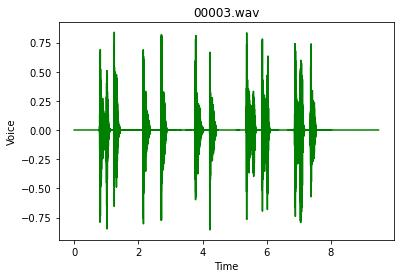

In [ ]:
wav_path = path + '/train/00003.wav'
(file_dir, file_id) = os.path.split(wav_path)
y,sr = librosa.load(wav_path, sr = CFG['SR'])

time = np.linspace(0, len(y)/sr, len(y))
fig, ax = plt.subplots()
ax.plot(time, y, color = 'g')
ax.set_xlabel('Time')
ax.set_ylabel('Voice')
plt.title(file_id)
plt.show()

In [ ]:
IPython.display.Audio(data = y, rate = sr)

In [ ]:
def get_pre_features(df, wav, save_path):
    zip_path = path
    
    if os.path.exists(save_path):
        return print(f'{save_path} is exist.')
    
    hop_length = CFG['SR'] * 0.01
    n_fft = CFG['SR'] * 0.025
    win_length = n_fft

    y_mean_mfcc = []
    
    for uid in tqdm(df.id):
        train_path = os.path.join(zip_path, wav)
        wav_path = os.path.join(train_path, str(uid).zfill(5) + '.wav')
        
        y, sr = librosa.load(wav_path, sr = CFG['SR'])
        
        mels = librosa.feature.melspectrogram(y, sr = sr, n_mels = CFG['N_MELS'])
        
        S = np.abs(mels)
        
        log_S = librosa.power_to_db(S, ref = np.max)
        
        mfcc = librosa.feature.mfcc(y = y, S = log_S, sr = sr, n_mfcc = CFG['N_MFCC'], n_fft = n_fft, win_length = win_length, hop_length = hop_length)
        
        x_mean_mfcc = []
        for item in mfcc:
            x_mean_mfcc.append(np.mean(item))
        y_mean_mfcc.append(x_mean_mfcc)

    mfcc_mean_df = pd.DataFrame(y_mean_mfcc, columns = ['mfcc_mean'+str(x) for x in range(1, CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_mean_df], axis = 1)
    
    df.to_csv(save_path, index = False)
    
    return df

In [ ]:
train_pre_df = get_pre_features(train_df, 'train', path + '/preprocess-df/train_mfcc_df.csv')
test_pre_df = get_pre_features(test_df, 'test', path + '/preprocess-df/test_mfcc_df.csv')
unlabeled_pre_df = get_pre_features(unlabeled_df, 'unlabeled', path + '/preprocess-df/unlabeled_mfcc_df.csv')

C:\Users\user\Downloads\neusi\Brno_FIT_VUT_2022\data/preprocess-df/train_mfcc_df.csv is exist.
C:\Users\user\Downloads\neusi\Brno_FIT_VUT_2022\data/preprocess-df/test_mfcc_df.csv is exist.
C:\Users\user\Downloads\neusi\Brno_FIT_VUT_2022\data/preprocess-df/unlabeled_mfcc_df.csv is exist.


In [ ]:
train_pre_df = pd.read_csv( path + '/preprocess-df/train_mfcc_df.csv')
test_pre_df = pd.read_csv(path + '/preprocess-df/test_mfcc_df.csv')
unlabeled_pre_df = pd.read_csv(path + '/preprocess-df/unlabeled_mfcc_df.csv')

In [ ]:
train_pre_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,...,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,mfcc_mean11,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15
0,1,24,female,0,1,0,-689.78260,30.519340,-20.314617,-6.689036,...,-7.443150,-33.740433,-11.282130,-6.180177,3.664029,-8.822412,11.487985,2.013037,5.346232,-8.968759
1,2,51,male,0,0,0,-646.08820,54.141323,-1.748550,-9.437219,...,-0.148136,-17.331127,0.516544,-5.485947,9.036359,-12.046542,4.550132,-11.630826,2.682697,-11.733445
2,3,22,male,0,0,0,-763.64870,46.675842,-22.771933,-3.527922,...,0.344213,-9.082897,-9.558626,-7.818271,2.704577,-7.542888,1.077480,-1.519363,-3.529857,-3.897850
3,4,29,female,1,0,0,-723.56230,47.762012,-8.256503,-2.891350,...,-8.495336,-11.653670,-11.117247,1.837300,-1.709650,-17.807985,5.599278,-8.676670,0.819343,-3.713208
4,5,23,male,0,0,0,-813.31647,7.509357,-7.762264,2.567660,...,-0.318077,-6.422602,-0.560701,0.094929,1.210430,-5.465760,-1.062964,-4.133721,-0.826705,-2.789167


In [ ]:
test_pre_df.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,mfcc_mean11,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15
0,3806,48,female,1,0,-876.15340,9.424123,0.727018,2.465860,-0.261858,-1.100758,-3.199885,-0.746239,-2.301054,0.230027,-1.991927,0.548587,-1.216551,-0.251188,0.047354
1,3807,24,female,0,0,-842.16230,8.865809,-3.128296,-2.435534,-3.131949,2.349788,-5.630660,0.027449,0.505046,0.624523,-1.372892,3.604210,-3.086343,0.003745,-0.863950
2,3808,29,male,0,0,-149.71188,-1.519202,-8.192215,0.108348,-6.175037,2.347849,-8.913834,-1.219602,-5.984417,-0.691460,-5.379525,-2.847182,-9.447227,-2.167787,-2.867867
3,3809,39,female,0,0,-790.97205,27.674364,-9.778633,10.285870,-1.541319,-3.504865,-14.483954,-11.274062,0.127190,-0.549245,-14.055302,0.527318,-4.198510,-4.865909,-6.291567
4,3810,34,male,0,0,-751.44720,45.460460,-14.742424,-2.684571,-10.204906,10.337976,-1.117903,-6.099093,-7.122675,-9.332335,-6.210151,1.704028,-5.869286,3.388353,-4.276303


In [ ]:
train_pre_df_copy = train_pre_df.copy()
test_pre_df_copy = test_pre_df.copy()
unlabeled_pre_df_copy = unlabeled_pre_df.copy()

In [ ]:
train_pre_df_copy.shape, test_pre_df_copy.shape, unlabeled_pre_df_copy.shape
# train_pre_df_copy.shape, test_pre_df_copy.shape

((3805, 21), (5732, 20), (1867, 20))

In [ ]:
def onehot_encoder_(encoder, x, col_list):
    for col in col_list:
        encoder = encoder
        encoder.fit(x[col].values.reshape(-1, 1))
        encoded = encoder.transform(x[col].values.reshape(-1, 1))
        encoded_df = pd.DataFrame(encoded, columns = encoder.categories_[0])
        x = pd.concat([x.drop(columns = [col]), encoded_df], axis = 1)
    return x

def label_encoder_(encoder, x, col_list):
    for col in col_list:
        encoder = encoder
        encoder.fit(x[col].values.reshape(-1, 1))
        x[col] = encoder.transform(x[col].values.reshape(-1, 1))
    return x

In [ ]:
col_list = ['gender']
encoder = OneHotEncoder(sparse = False)
train_pre_df_copy = onehot_encoder_(encoder, train_pre_df_copy, col_list)
test_pre_df_copy = onehot_encoder_(encoder, test_pre_df_copy, col_list)
unlabeled_pre_df_copy = onehot_encoder_(encoder, unlabeled_pre_df_copy, col_list)

In [ ]:
train_pre_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3805 entries, 0 to 3804
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3805 non-null   int64  
 1   age                    3805 non-null   int64  
 2   respiratory_condition  3805 non-null   int64  
 3   fever_or_muscle_pain   3805 non-null   int64  
 4   covid19                3805 non-null   int64  
 5   mfcc_mean1             3805 non-null   float64
 6   mfcc_mean2             3805 non-null   float64
 7   mfcc_mean3             3805 non-null   float64
 8   mfcc_mean4             3805 non-null   float64
 9   mfcc_mean5             3805 non-null   float64
 10  mfcc_mean6             3805 non-null   float64
 11  mfcc_mean7             3805 non-null   float64
 12  mfcc_mean8             3805 non-null   float64
 13  mfcc_mean9             3805 non-null   float64
 14  mfcc_mean10            3805 non-null   float64
 15  mfcc

In [ ]:
train_x = train_pre_df_copy.drop(columns=['id', 'covid19'])
train_y = train_pre_df_copy['covid19']

In [ ]:
test_x = test_pre_df_copy[train_x.columns]
unlabeled_x = unlabeled_pre_df_copy[train_x.columns]

In [ ]:
model = MLPClassifier(activation = 'relu', solver = 'adam', random_state=seed)
model.fit(train_x, train_y)
# Model save
pass
prob = model.predict_proba(unlabeled_x)
# semiprediction = model.predict(unlabeled_x)
# prob = model.predict_proba(test_x)
# prob = model.predict(test_x)
# semiprediction = model.predict(test_x)
semiprediction = np.where(prob < 0.487, 1, 0)
# prediction = np.where(prob < 0.487, 1, 0)
# prediction2 = np.where(prob < 0.663, 1, 0)


In [ ]:
# print(prob)
print(semiprediction)
# print(prediction)

[[1 0]
 [1 0]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [ ]:
print(semiprediction.shape)

(1867, 2)


In [ ]:
unlabeled_x['covid19'] = -1
unlabeled_x['covid19'] = semiprediction

In [ ]:
unlabeled_x.covid19.value_counts()

0    1124
1     743
Name: covid19, dtype: int64

In [ ]:
unlabeled_y = unlabeled_x['covid19']
unlabeled_x = unlabeled_x.drop(['covid19'], axis = 1)

In [ ]:
test_x

,age,respiratory_condition,fever_or_muscle_pain,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,...,mfcc_mean9,mfcc_mean10,mfcc_mean11,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15,female,male,other
0,48,1,0,-876.15340,9.424123,0.727018,2.465860,-0.261858,-1.100758,-3.199885,...,-2.301054,0.230027,-1.991927,0.548587,-1.216551,-0.251188,0.047354,1.0,0.0,0.0
1,24,0,0,-842.16230,8.865809,-3.128296,-2.435534,-3.131949,2.349788,-5.630660,...,0.505046,0.624523,-1.372892,3.604210,-3.086343,0.003745,-0.863950,1.0,0.0,0.0
2,29,0,0,-149.71188,-1.519202,-8.192215,0.108348,-6.175037,2.347849,-8.913834,...,-5.984417,-0.691460,-5.379525,-2.847182,-9.447227,-2.167787,-2.867867,0.0,1.0,0.0
3,39,0,0,-790.97205,27.674364,-9.778633,10.285870,-1.541319,-3.504865,-14.483954,...,0.127190,-0.549245,-14.055302,0.527318,-4.198510,-4.865909,-6.291567,1.0,0.0,0.0
4,34,0,0,-751.44720,45.460460,-14.742424,-2.684571,-10.204906,10.337976,-1.117903,...,-7.122675,-9.332335,-6.210151,1.704028,-5.869286,3.388353,-4.276303,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5727,43,0,0,-733.99790,48.446053,6.146006,12.088921,-8.301061,-1.040587,-11.340342,...,-6.559079,4.875961,-3.317399,-5.773796,-13.808950,-2.782616,-4.771538,0.0,1.0,0.0
5728,48,0,1,-852.30030,3.089390,1.821568,5.398409,-4.807905,-3.338210,-7.359061,...,-3.487487,0.601855,-3.843679,2.148583,-3.255516,0.399457,-1.714822,1.0,0.0,0.0
5729,44,0,0,-677.26917,54.853344,-16.275513,14.433867,-9.924277,-5.135542,-28.151585,...,-12.481259,-2.381428,-7.718770,3.247548,-7.431384,-2.775975,-0.803070,1.0,0.0,0.0
5730,25,0,0,-818.26360,17.660162,-9.821951,5.716813,-8.438224,0.311916,-11.437690,...,-2.343676,0.940116,-4.015154,-2.752056,-4.449954,-4.985150,-4.148751,1.0,0.0,0.0


In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=seed)

all_x = pd.concat([train_x, unlabeled_x], axis=0)
all_y = pd.concat([train_y, unlabeled_y], axis=0)

In [ ]:
from dataclasses import dataclass

# model = MLPClassifier(activation = 'relu', solver = 'adam', random_state=seed)
# model.fit(all_x, all_y)
# prob = model.predict_proba(test_x)
model = MLPClassifier(activation = 'relu', solver = 'adam', random_state=seed)
model.fit(all_x, all_y)
prob = model.predict_proba(val_x)
# prob = model.predict(test_x)
# prediction = np.where(prob < 0.663, 1, 0)
y_pred = np.where(prob < 0.663, 1, 0)

accuracy = accuracy_score(y_pred[:, 0], val_y)
print("Accuracy = "+ format(accuracy * 100, ".2f") + "%")

Accuracy = 87.65 %


-----------

# Real data test

In [ ]:
# path = r'C:\Users\user\Downloads\neusi\Brno_FIT_VUT_2022\data'

# # Only id 0 data is real data. Other data need for making categories
# real_df = pd.read_csv(path + '/real_data.csv')
# real_pre_df = get_pre_features(real_df, 'real', path + '/preprocess-df/real_mfcc_df.csv')
# real_pre_df = pd.read_csv( path + '/preprocess-df/real_mfcc_df.csv')
# real_pre_df.head()

In [ ]:
# real_pre_df_copy = real_pre_df.copy()
# real_pre_df_copy.shape

In [ ]:
# col_list = ['gender']
# encoder = OneHotEncoder(sparse = False)
# real_pre_df_copy = onehot_encoder_(encoder, real_pre_df_copy, col_list)
# real_pre_df_copy.info()

# real_x = real_pre_df_copy.drop(columns=['id', 'covid19'])
# real_y = real_pre_df_copy['covid19']

In [ ]:
# real_prob = model.predict_proba(real_x)
# real_pred = np.where(real_prob < 0.663, 1, 0)

# print(f"Predict: {real_pred[0, 0]}, True: {real_y[0]}" )

In [ ]:
# real_pred[:, 0] == real_y

# For competition

In [ ]:
# # submission = pd.read_csv(path + '/sample_submission.csv')
# # submission['covid19'] = prediction
# # submission.to_csv('./submission.csv', index=False)
# submission = pd.read_csv(path + '/sample_submission.csv')
# submission['covid19'] = prediction
# # submission['covid19'] = prob
# submission.to_csv(path + '/submission.csv', index=False)

In [ ]:
# submission.covid19.value_counts()

In [ ]:
# submission